# Task 5: Strategy Backtesting
## GMF Investments - Portfolio Optimization

**Objective:** Validate portfolio strategy by simulating its performance on historical data and comparing it against a benchmark.

**Key Activities:**
1. Define backtesting period (last year: 2025-2026)
2. Define benchmark portfolio (60% SPY / 40% BND)
3. Simulate strategy performance
4. Analyze and compare performance metrics
5. Conclude on strategy viability

**Philosophy:**
> "A forecast and an optimized portfolio are hypotheses. A backtest is the experiment that validates them."

---

### Backtesting Purpose:
- Validate model-driven approach
- Compare against passive benchmark
- Understand real-world performance
- Identify strategy limitations

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)

# Visualization settings
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("Libraries imported successfully!")
print("Backtesting tools ready!")

Libraries imported successfully!
Backtesting tools ready!


## 1. Load Data and Portfolio Weights

In [2]:
# Load historical data for all assets
print("Loading historical data for TSLA, BND, and SPY...")

assets = ['TSLA', 'BND', 'SPY']
data = {}

for asset in assets:
    try:
        df = pd.read_csv(f'../data/processed/{asset}_processed.csv', 
                        skiprows=[1, 2], index_col=0)
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        
        # Extract closing prices
        close_prices = df['Close'].copy()
        if isinstance(close_prices, pd.DataFrame):
            close_prices = close_prices.iloc[:, 0]
        
        data[asset] = close_prices
        print(f"✓ {asset}: {len(close_prices)} days ({close_prices.index[0].date()} to {close_prices.index[-1].date()})")
    except FileNotFoundError:
        print(f"⚠️ {asset} data not found")

# Create combined prices dataframe
prices_df = pd.DataFrame(data)
prices_df = prices_df.dropna()

print(f"\n✓ Combined prices dataframe created")
print(f"  Shape: {prices_df.shape}")
print(f"  Date range: {prices_df.index[0].date()} to {prices_df.index[-1].date()}")

Loading historical data for TSLA, BND, and SPY...
✓ TSLA: 2775 days (2015-01-02 to 2026-01-14)
✓ BND: 2775 days (2015-01-02 to 2026-01-14)
✓ SPY: 2775 days (2015-01-02 to 2026-01-14)

✓ Combined prices dataframe created
  Shape: (2775, 3)
  Date range: 2015-01-02 to 2026-01-14


In [3]:
# Load optimal portfolio weights from Task 4
print("\nLoading optimal portfolio weights from Task 4...")
try:
    import json
    with open('../data/processed/portfolio_optimization.json', 'r') as f:
        portfolio_data = json.load(f)
    
    # Get recommended portfolio weights
    if 'Recommended' in portfolio_data:
        strategy_weights = {
            'TSLA': portfolio_data['Recommended']['TSLA'],
            'BND': portfolio_data['Recommended']['BND'],
            'SPY': portfolio_data['Recommended']['SPY']
        }
        print("✓ Loaded recommended portfolio weights from Task 4")
    elif 'Max_Sharpe' in portfolio_data:
        strategy_weights = {
            'TSLA': portfolio_data['Max_Sharpe']['TSLA'],
            'BND': portfolio_data['Max_Sharpe']['BND'],
            'SPY': portfolio_data['Max_Sharpe']['SPY']
        }
        print("✓ Loaded Max Sharpe portfolio weights from Task 4")
    else:
        raise KeyError("No recommended portfolio found")
    
    print(f"\nStrategy Portfolio Weights:")
    for asset, weight in strategy_weights.items():
        print(f"  {asset}: {weight*100:.2f}%")
    
except FileNotFoundError:
    print("⚠️ Portfolio optimization file not found.")
    print("Using default weights (will need to run Task 4 first)")
    strategy_weights = None
except KeyError as e:
    print(f"⚠️ Error loading portfolio: {e}")
    strategy_weights = None


Loading optimal portfolio weights from Task 4...
✓ Loaded recommended portfolio weights from Task 4

Strategy Portfolio Weights:
  TSLA: 0.00%
  BND: 0.00%
  SPY: 100.00%


## 2. Define Backtesting Period

BACKTESTING PERIOD DEFINITION

Backtesting Period:
  Start: 2025-01-02
  End: 2026-01-14
  Trading Days: 259
  Duration: 377 days

✓ Backtesting data prepared
  Returns shape: (258, 3)
  Returns date range: 2025-01-03 to 2026-01-14


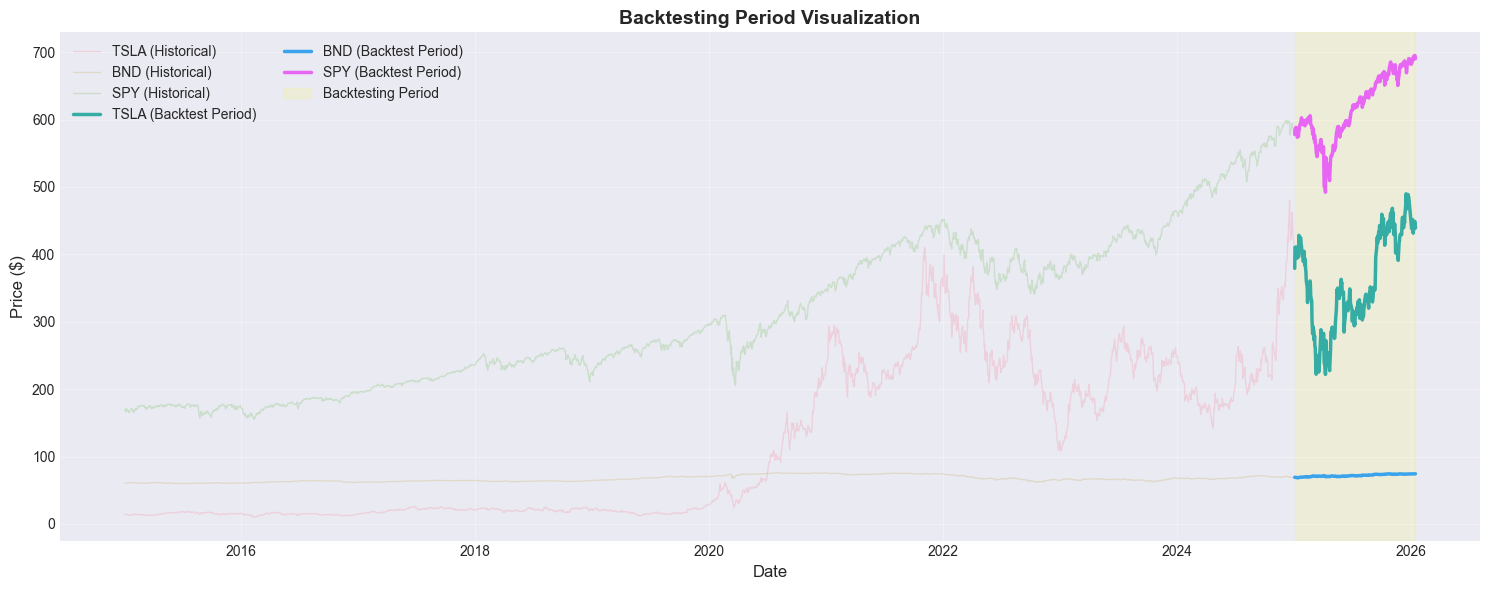

In [4]:
# Define backtesting period (last year: 2025-2026)
# This should be data NOT used for training
backtest_start = '2025-01-01'
backtest_end = '2026-01-15'

print("="*70)
print("BACKTESTING PERIOD DEFINITION")
print("="*70)

# Filter data for backtesting period
backtest_data = prices_df[(prices_df.index >= backtest_start) & (prices_df.index <= backtest_end)].copy()

if len(backtest_data) == 0:
    # If no data in that range, use last year of available data
    print("⚠️ No data in specified range. Using last year of available data...")
    last_date = prices_df.index[-1]
    first_date = last_date - pd.DateOffset(years=1)
    backtest_data = prices_df[prices_df.index >= first_date].copy()

print(f"\nBacktesting Period:")
print(f"  Start: {backtest_data.index[0].date()}")
print(f"  End: {backtest_data.index[-1].date()}")
print(f"  Trading Days: {len(backtest_data)}")
print(f"  Duration: {(backtest_data.index[-1] - backtest_data.index[0]).days} days")

# Calculate daily returns for backtesting period
backtest_returns = backtest_data.pct_change().dropna()

print(f"\n✓ Backtesting data prepared")
print(f"  Returns shape: {backtest_returns.shape}")
print(f"  Returns date range: {backtest_returns.index[0].date()} to {backtest_returns.index[-1].date()}")

# Visualize backtesting period
fig, ax = plt.subplots(figsize=(15, 6))

# Plot full historical data (light)
for asset in assets:
    if asset in prices_df.columns:
        ax.plot(prices_df.index, prices_df[asset], 
               alpha=0.2, linewidth=1, label=f'{asset} (Historical)')

# Highlight backtesting period
for asset in assets:
    if asset in backtest_data.columns:
        ax.plot(backtest_data.index, backtest_data[asset], 
               linewidth=2.5, label=f'{asset} (Backtest Period)')

ax.axvspan(backtest_data.index[0], backtest_data.index[-1], 
          alpha=0.1, color='yellow', label='Backtesting Period')
ax.set_title('Backtesting Period Visualization', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price ($)', fontsize=12)
ax.legend(loc='best', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
# Define benchmark portfolio: 60% SPY / 40% BND (balanced portfolio)
benchmark_weights = {
    'TSLA': 0.0,
    'BND': 0.4,
    'SPY': 0.6
}

print("="*70)
print("BENCHMARK PORTFOLIO DEFINITION")
print("="*70)
print("\nBenchmark: Static Balanced Portfolio")
print("  60% SPY (S&P 500 ETF) - Broad market exposure")
print("  40% BND (Bond ETF) - Stability and income")
print("  0% TSLA - No active stock selection")

print(f"\nBenchmark Portfolio Weights:")
for asset, weight in benchmark_weights.items():
    print(f"  {asset}: {weight*100:.2f}%")

# Verify weights sum to 1
assert abs(sum(benchmark_weights.values()) - 1.0) < 0.001, "Benchmark weights must sum to 1"
print(f"\n✓ Benchmark weights validated (sum = {sum(benchmark_weights.values()):.4f})")

BENCHMARK PORTFOLIO DEFINITION

Benchmark: Static Balanced Portfolio
  60% SPY (S&P 500 ETF) - Broad market exposure
  40% BND (Bond ETF) - Stability and income
  0% TSLA - No active stock selection

Benchmark Portfolio Weights:
  TSLA: 0.00%
  BND: 40.00%
  SPY: 60.00%

✓ Benchmark weights validated (sum = 1.0000)


## 4. Simulate Strategy Performance

In [6]:
# Check if strategy weights are available
if strategy_weights is None:
    print("⚠️ Strategy weights not available. Please run Task 4 first.")
    print("Using equal weights as placeholder...")
    strategy_weights = {
        'TSLA': 0.33,
        'BND': 0.33,
        'SPY': 0.34
    }

print("="*70)
print("STRATEGY SIMULATION")
print("="*70)

# Strategy: Hold initial optimal weights for the full backtesting period
print("\nStrategy: Hold optimal weights for full backtesting period")
print("  (No rebalancing - buy and hold approach)")

# Calculate portfolio returns
def calculate_portfolio_returns(returns_df, weights):
    """Calculate portfolio returns given asset returns and weights"""
    # Ensure weights are in correct order
    weight_vector = np.array([weights.get(asset, 0) for asset in returns_df.columns])
    
    # Calculate daily portfolio returns
    portfolio_returns = (returns_df * weight_vector).sum(axis=1)
    
    return portfolio_returns

# Calculate strategy portfolio returns
strategy_returns = calculate_portfolio_returns(backtest_returns, strategy_weights)

# Calculate benchmark portfolio returns
benchmark_returns = calculate_portfolio_returns(backtest_returns, benchmark_weights)

print(f"\n✓ Portfolio returns calculated")
print(f"  Strategy returns: {len(strategy_returns)} days")
print(f"  Benchmark returns: {len(benchmark_returns)} days")

# Calculate cumulative returns
strategy_cumulative = (1 + strategy_returns).cumprod()
benchmark_cumulative = (1 + benchmark_returns).cumprod()

# Normalize to start at 1.0
strategy_cumulative = strategy_cumulative / strategy_cumulative.iloc[0]
benchmark_cumulative = benchmark_cumulative / benchmark_cumulative.iloc[0]

print(f"\n✓ Cumulative returns calculated")
print(f"  Strategy final value: ${strategy_cumulative.iloc[-1]:.4f} (${(strategy_cumulative.iloc[-1]-1)*100:.2f}% return)")
print(f"  Benchmark final value: ${benchmark_cumulative.iloc[-1]:.4f} (${(benchmark_cumulative.iloc[-1]-1)*100:.2f}% return)")

STRATEGY SIMULATION

Strategy: Hold optimal weights for full backtesting period
  (No rebalancing - buy and hold approach)

✓ Portfolio returns calculated
  Strategy returns: 258 days
  Benchmark returns: 258 days

✓ Cumulative returns calculated
  Strategy final value: $1.1799 ($17.99% return)
  Benchmark final value: $1.1427 ($14.27% return)


### 4.1 Advanced: Monthly Rebalancing (Optional)

In [7]:
# Optional: Simulate with monthly rebalancing
print("\n" + "="*70)
print("ADVANCED: MONTHLY REBALANCING SIMULATION")
print("="*70)

# Group returns by month
backtest_returns['YearMonth'] = backtest_returns.index.to_period('M')

# Initialize portfolio value
initial_value = 1.0
strategy_value_rebalanced = initial_value
benchmark_value_rebalanced = initial_value

strategy_values_rebalanced = [initial_value]
benchmark_values_rebalanced = [initial_value]
rebalance_dates = [backtest_returns.index[0]]

# Process month by month
for month, group in backtest_returns.groupby('YearMonth'):
    if len(group) == 0:
        continue
    
    # Calculate returns for this month
    month_strategy_returns = calculate_portfolio_returns(group.drop('YearMonth', axis=1), strategy_weights)
    month_benchmark_returns = calculate_portfolio_returns(group.drop('YearMonth', axis=1), benchmark_weights)
    
    # Apply returns to portfolio values
    strategy_value_rebalanced *= (1 + month_strategy_returns).prod()
    benchmark_value_rebalanced *= (1 + month_benchmark_returns).prod()
    
    # Record value at end of month
    strategy_values_rebalanced.append(strategy_value_rebalanced)
    benchmark_values_rebalanced.append(benchmark_value_rebalanced)
    rebalance_dates.append(group.index[-1])

# Create rebalanced cumulative series
strategy_cumulative_rebalanced = pd.Series(strategy_values_rebalanced, index=rebalance_dates)
benchmark_cumulative_rebalanced = pd.Series(benchmark_values_rebalanced, index=rebalance_dates)

print(f"✓ Monthly rebalancing simulation completed")
print(f"  Strategy (rebalanced) final value: ${strategy_cumulative_rebalanced.iloc[-1]:.4f}")
print(f"  Benchmark (rebalanced) final value: ${benchmark_cumulative_rebalanced.iloc[-1]:.4f}")
print(f"  Number of rebalancing periods: {len(strategy_cumulative_rebalanced) - 1}")


ADVANCED: MONTHLY REBALANCING SIMULATION
✓ Monthly rebalancing simulation completed
  Strategy (rebalanced) final value: $1.1947
  Benchmark (rebalanced) final value: $1.1507
  Number of rebalancing periods: 13


## 5. Visualize Performance Comparison

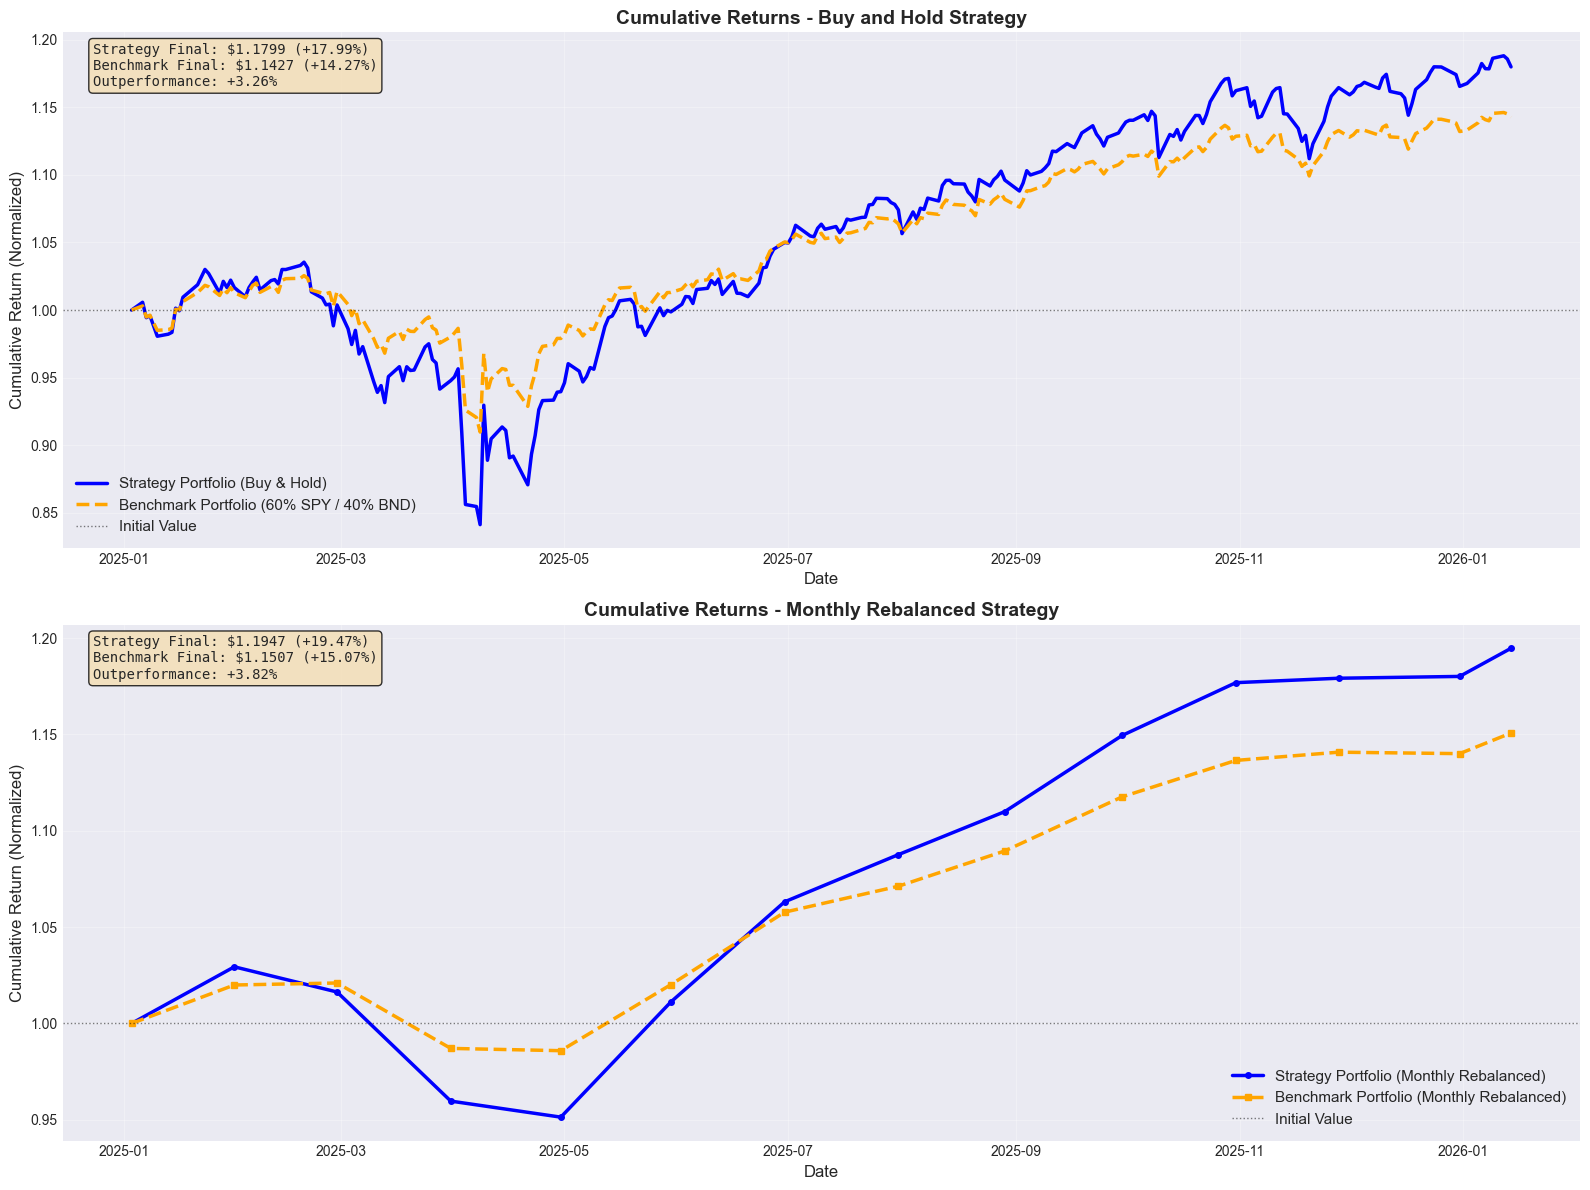

In [8]:
# Plot cumulative returns comparison
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Buy and Hold Strategy
axes[0].plot(strategy_cumulative.index, strategy_cumulative.values,
            label='Strategy Portfolio (Buy & Hold)', color='blue', linewidth=2.5)
axes[0].plot(benchmark_cumulative.index, benchmark_cumulative.values,
            label='Benchmark Portfolio (60% SPY / 40% BND)', color='orange', linewidth=2.5, linestyle='--')
axes[0].axhline(y=1.0, color='black', linestyle=':', linewidth=1, alpha=0.5, label='Initial Value')
axes[0].set_title('Cumulative Returns - Buy and Hold Strategy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Cumulative Return (Normalized)', fontsize=12)
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Add performance annotation
strategy_final = strategy_cumulative.iloc[-1]
benchmark_final = benchmark_cumulative.iloc[-1]
outperformance = (strategy_final - benchmark_final) / benchmark_final * 100

textstr = f'Strategy Final: ${strategy_final:.4f} ({((strategy_final-1)*100):+.2f}%)\n'
textstr += f'Benchmark Final: ${benchmark_final:.4f} ({((benchmark_final-1)*100):+.2f}%)\n'
textstr += f'Outperformance: {outperformance:+.2f}%'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
axes[0].text(0.02, 0.98, textstr, transform=axes[0].transAxes, fontsize=10,
            verticalalignment='top', bbox=props, family='monospace')

# Plot 2: Monthly Rebalanced Strategy
axes[1].plot(strategy_cumulative_rebalanced.index, strategy_cumulative_rebalanced.values,
            label='Strategy Portfolio (Monthly Rebalanced)', color='blue', linewidth=2.5, marker='o', markersize=4)
axes[1].plot(benchmark_cumulative_rebalanced.index, benchmark_cumulative_rebalanced.values,
            label='Benchmark Portfolio (Monthly Rebalanced)', color='orange', linewidth=2.5, 
            linestyle='--', marker='s', markersize=4)
axes[1].axhline(y=1.0, color='black', linestyle=':', linewidth=1, alpha=0.5, label='Initial Value')
axes[1].set_title('Cumulative Returns - Monthly Rebalanced Strategy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Cumulative Return (Normalized)', fontsize=12)
axes[1].legend(loc='best', fontsize=11)
axes[1].grid(True, alpha=0.3)

# Add performance annotation for rebalanced
strategy_final_reb = strategy_cumulative_rebalanced.iloc[-1]
benchmark_final_reb = benchmark_cumulative_rebalanced.iloc[-1]
outperformance_reb = (strategy_final_reb - benchmark_final_reb) / benchmark_final_reb * 100

textstr_reb = f'Strategy Final: ${strategy_final_reb:.4f} ({((strategy_final_reb-1)*100):+.2f}%)\n'
textstr_reb += f'Benchmark Final: ${benchmark_final_reb:.4f} ({((benchmark_final_reb-1)*100):+.2f}%)\n'
textstr_reb += f'Outperformance: {outperformance_reb:+.2f}%'

axes[1].text(0.02, 0.98, textstr_reb, transform=axes[1].transAxes, fontsize=10,
            verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
plt.show()

## 6. Calculate Performance Metrics

In [9]:
# Calculate comprehensive performance metrics
print("="*70)
print("PERFORMANCE METRICS CALCULATION")
print("="*70)

def calculate_metrics(returns, name, risk_free_rate=0.02):
    """Calculate comprehensive performance metrics"""
    # Total return
    total_return = (1 + returns).prod() - 1
    
    # Annualized return
    trading_days = len(returns)
    years = trading_days / 252
    annualized_return = (1 + total_return) ** (1 / years) - 1
    
    # Volatility (annualized)
    volatility = returns.std() * np.sqrt(252)
    
    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility
    
    # Maximum Drawdown
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Additional metrics
    win_rate = (returns > 0).sum() / len(returns) * 100
    avg_win = returns[returns > 0].mean() if (returns > 0).any() else 0
    avg_loss = returns[returns < 0].mean() if (returns < 0).any() else 0
    
    return {
        'Portfolio': name,
        'Total Return (%)': total_return * 100,
        'Annualized Return (%)': annualized_return * 100,
        'Volatility (%)': volatility * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown * 100,
        'Win Rate (%)': win_rate,
        'Avg Daily Return (%)': returns.mean() * 100
    }

# Calculate metrics for both strategies
strategy_metrics = calculate_metrics(strategy_returns, 'Strategy Portfolio')
benchmark_metrics = calculate_metrics(benchmark_returns, 'Benchmark Portfolio')

# Create comparison dataframe
metrics_df = pd.DataFrame([strategy_metrics, benchmark_metrics])

print("\n" + "="*70)
print("PERFORMANCE METRICS COMPARISON")
print("="*70)
print(metrics_df.to_string(index=False))

# Calculate outperformance
outperformance_metrics = {}
for metric in ['Total Return (%)', 'Annualized Return (%)', 'Sharpe Ratio']:
    strategy_val = strategy_metrics[metric]
    benchmark_val = benchmark_metrics[metric]
    if metric == 'Sharpe Ratio':
        outperformance_metrics[metric] = strategy_val - benchmark_val
    else:
        outperformance_metrics[metric] = strategy_val - benchmark_val

print("\n" + "="*70)
print("OUTPERFORMANCE ANALYSIS")
print("="*70)
for metric, value in outperformance_metrics.items():
    if metric == 'Sharpe Ratio':
        print(f"  {metric}: {value:+.4f}")
    else:
        print(f"  {metric}: {value:+.2f} percentage points")

PERFORMANCE METRICS CALCULATION

PERFORMANCE METRICS COMPARISON
          Portfolio  Total Return (%)  Annualized Return (%)  Volatility (%)  Sharpe Ratio  Max Drawdown (%)  Win Rate (%)  Avg Daily Return (%)
 Strategy Portfolio           19.4696                18.9764         19.2179        0.8834          -18.7552       57.3643                0.0762
Benchmark Portfolio           15.0713                14.6962         11.8182        1.0743          -11.2888       56.9767                0.0572

OUTPERFORMANCE ANALYSIS
  Total Return (%): +4.40 percentage points
  Annualized Return (%): +4.28 percentage points
  Sharpe Ratio: -0.1909


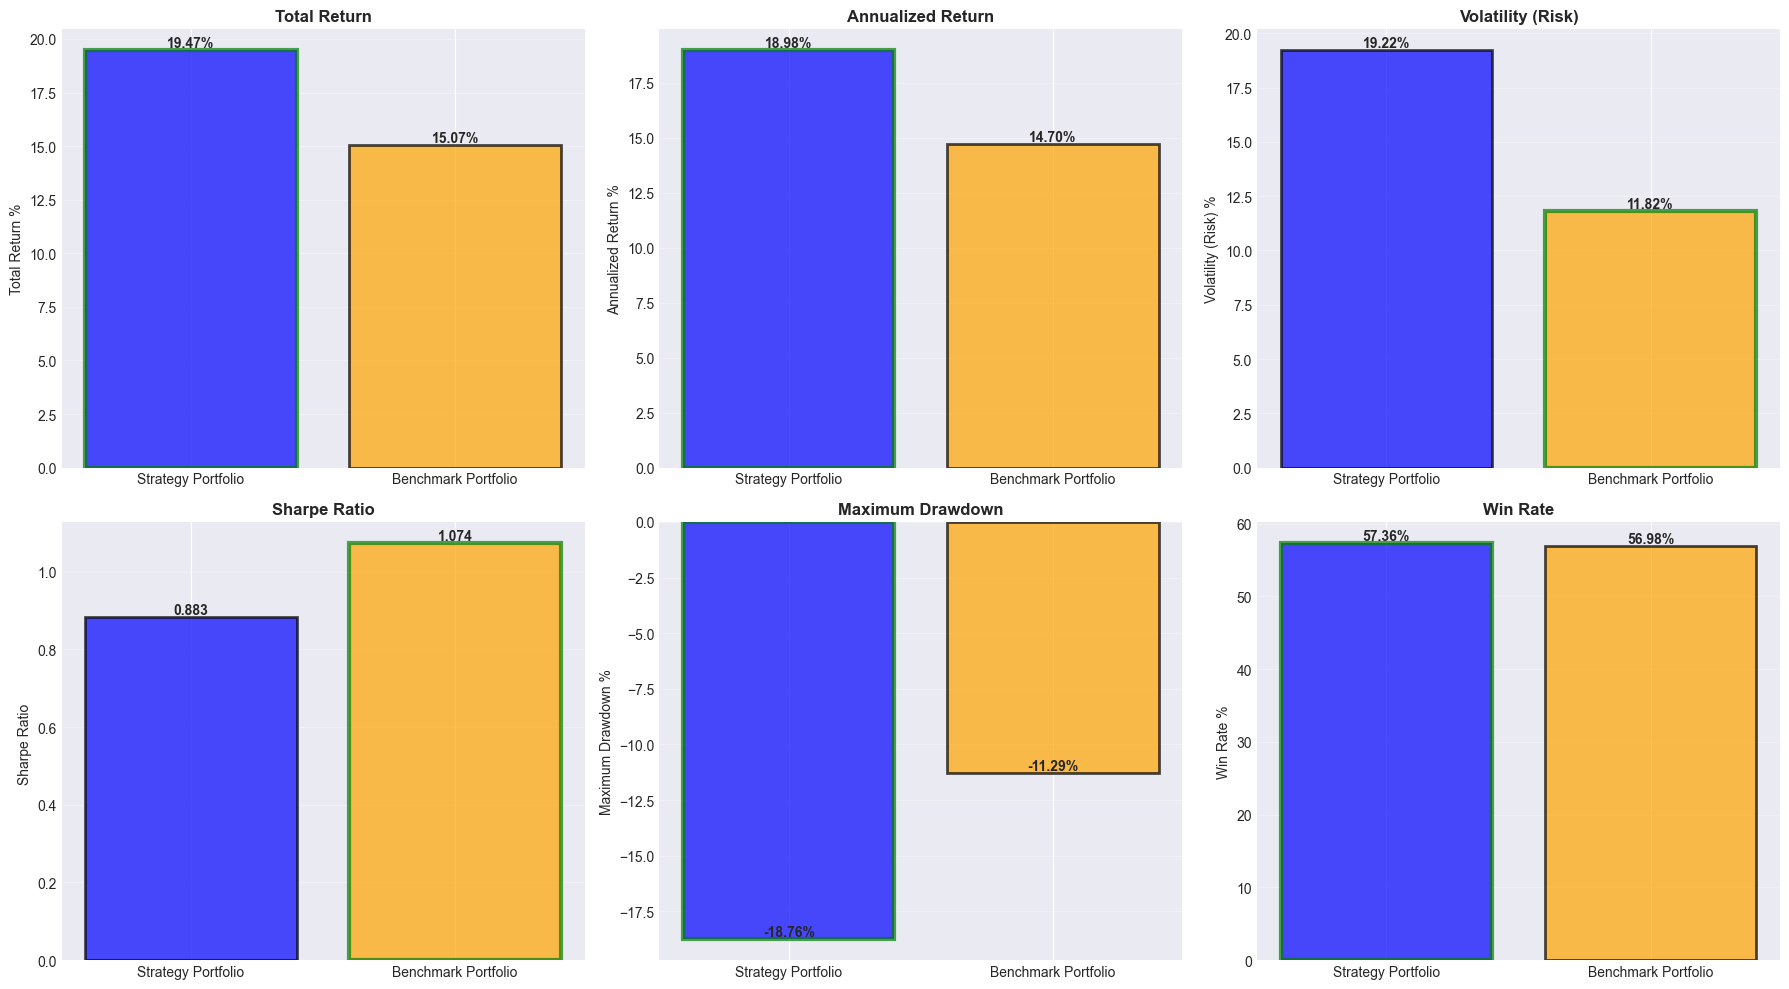

In [10]:
# Visualize performance metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics_to_plot = [
    ('Total Return (%)', 'Total Return', '%'),
    ('Annualized Return (%)', 'Annualized Return', '%'),
    ('Volatility (%)', 'Volatility (Risk)', '%'),
    ('Sharpe Ratio', 'Sharpe Ratio', ''),
    ('Max Drawdown (%)', 'Maximum Drawdown', '%'),
    ('Win Rate (%)', 'Win Rate', '%')
]

for idx, (metric_key, metric_name, unit) in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    values = metrics_df[metric_key].values
    portfolios = metrics_df['Portfolio'].values
    
    bars = ax.bar(portfolios, values, color=['blue', 'orange'], 
                  alpha=0.7, edgecolor='black', linewidth=2)
    
    # Add value labels
    for bar, value in zip(bars, values):
        height = bar.get_height()
        if unit == '%':
            label = f'{value:.2f}%'
        else:
            label = f'{value:.3f}'
        ax.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Highlight better performance
    if metric_key in ['Total Return (%)', 'Annualized Return (%)', 'Sharpe Ratio', 'Win Rate (%)']:
        best_idx = np.argmax(values)
        bars[best_idx].set_edgecolor('green')
        bars[best_idx].set_linewidth(3)
    elif metric_key in ['Volatility (%)', 'Max Drawdown (%)']:
        best_idx = np.argmin(values)
        bars[best_idx].set_edgecolor('green')
        bars[best_idx].set_linewidth(3)
    
    ax.set_title(metric_name, fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{metric_name} {unit}', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticklabels(portfolios, rotation=0)

plt.tight_layout()
plt.show()

### 6.1 Drawdown Analysis

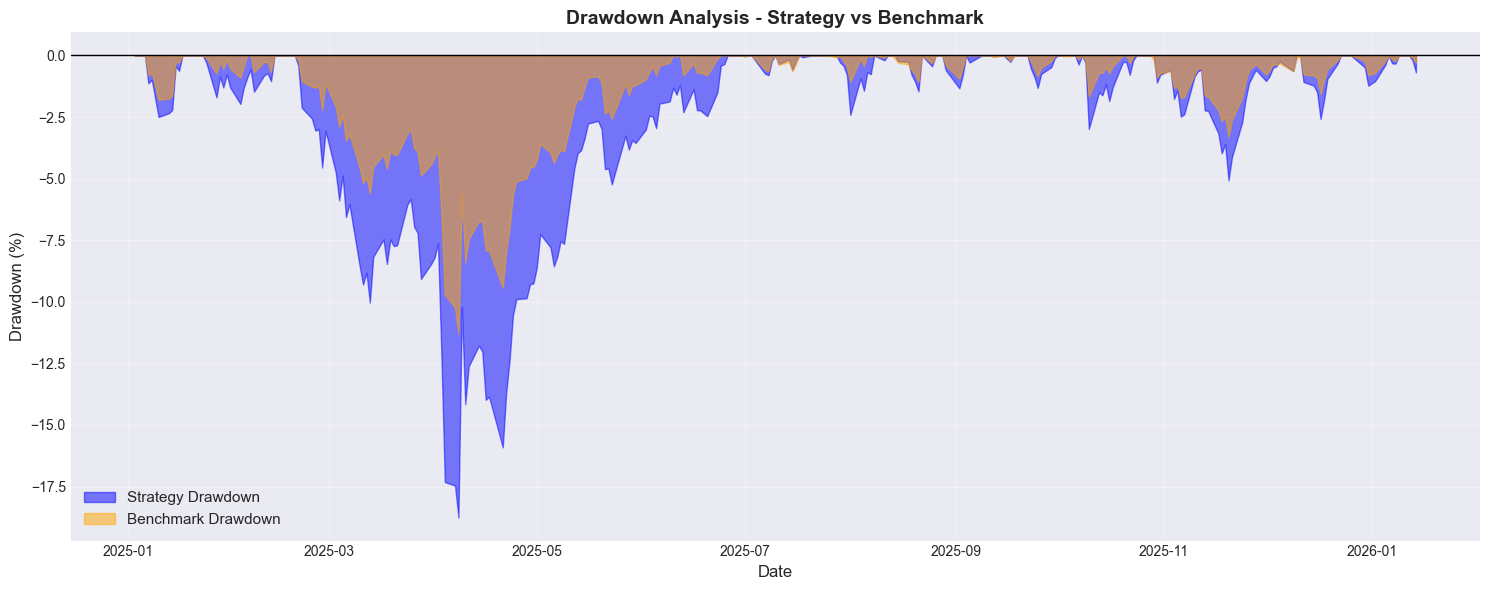


DRAWDOWN STATISTICS

Strategy Portfolio:
  Maximum Drawdown: -18.76%
  Average Drawdown: -3.36%
  Days in Drawdown: 208 (80.6%)

Benchmark Portfolio:
  Maximum Drawdown: -11.29%
  Average Drawdown: -1.85%
  Days in Drawdown: 199 (77.1%)


In [11]:
# Calculate and visualize drawdowns
def calculate_drawdown(returns):
    """Calculate drawdown series"""
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    return drawdown

strategy_drawdown = calculate_drawdown(strategy_returns)
benchmark_drawdown = calculate_drawdown(benchmark_returns)

# Plot drawdowns
fig, ax = plt.subplots(figsize=(15, 6))

ax.fill_between(strategy_drawdown.index, 0, strategy_drawdown.values * 100,
                alpha=0.5, color='blue', label='Strategy Drawdown')
ax.fill_between(benchmark_drawdown.index, 0, benchmark_drawdown.values * 100,
                alpha=0.5, color='orange', label='Benchmark Drawdown')

ax.set_title('Drawdown Analysis - Strategy vs Benchmark', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Drawdown (%)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)

plt.tight_layout()
plt.show()

# Drawdown statistics
print("\n" + "="*70)
print("DRAWDOWN STATISTICS")
print("="*70)
print(f"\nStrategy Portfolio:")
print(f"  Maximum Drawdown: {strategy_drawdown.min()*100:.2f}%")
print(f"  Average Drawdown: {strategy_drawdown[strategy_drawdown < 0].mean()*100:.2f}%")
print(f"  Days in Drawdown: {(strategy_drawdown < 0).sum()} ({(strategy_drawdown < 0).sum()/len(strategy_drawdown)*100:.1f}%)")

print(f"\nBenchmark Portfolio:")
print(f"  Maximum Drawdown: {benchmark_drawdown.min()*100:.2f}%")
print(f"  Average Drawdown: {benchmark_drawdown[benchmark_drawdown < 0].mean()*100:.2f}%")
print(f"  Days in Drawdown: {(benchmark_drawdown < 0).sum()} ({(benchmark_drawdown < 0).sum()/len(benchmark_drawdown)*100:.1f}%)")

## 7. Strategy Viability Analysis and Conclusion

In [12]:
print("="*70)
print("STRATEGY VIABILITY ANALYSIS")
print("="*70)

# Determine if strategy outperformed
strategy_ann_ret = strategy_metrics['Annualized Return (%)']
benchmark_ann_ret = benchmark_metrics['Annualized Return (%)']
strategy_sharpe = strategy_metrics['Sharpe Ratio']
benchmark_sharpe = benchmark_metrics['Sharpe Ratio']

outperformed_return = strategy_ann_ret > benchmark_ann_ret
outperformed_sharpe = strategy_sharpe > benchmark_sharpe

print(f"\n📊 PERFORMANCE SUMMARY:")
print("-" * 70)
print(f"Strategy Annual Return: {strategy_ann_ret:.2f}%")
print(f"Benchmark Annual Return: {benchmark_ann_ret:.2f}%")
print(f"Return Outperformance: {'✓ YES' if outperformed_return else '✗ NO'} ({strategy_ann_ret - benchmark_ann_ret:+.2f}%)")

print(f"\nStrategy Sharpe Ratio: {strategy_sharpe:.3f}")
print(f"Benchmark Sharpe Ratio: {benchmark_sharpe:.3f}")
print(f"Sharpe Outperformance: {'✓ YES' if outperformed_sharpe else '✗ NO'} ({strategy_sharpe - benchmark_sharpe:+.4f})")

print(f"\nStrategy Max Drawdown: {strategy_metrics['Max Drawdown (%)']:.2f}%")
print(f"Benchmark Max Drawdown: {benchmark_metrics['Max Drawdown (%)']:.2f}%")

# Overall assessment
if outperformed_return and outperformed_sharpe:
    overall_assessment = "STRONG OUTPERFORMANCE"
    assessment_emoji = "🏆"
elif outperformed_return or outperformed_sharpe:
    overall_assessment = "MIXED PERFORMANCE"
    assessment_emoji = "📊"
else:
    overall_assessment = "UNDERPERFORMANCE"
    assessment_emoji = "⚠️"

print(f"\n{assessment_emoji} OVERALL ASSESSMENT: {overall_assessment}")

print(f"\n📝 CONCLUSION:")
print("-" * 70)
print(f"""
Based on the backtesting results over the period from {backtest_data.index[0].date()} to {backtest_data.index[-1].date()}:

{'The strategy portfolio demonstrated strong performance' if outperformed_return and outperformed_sharpe else 
'The strategy portfolio showed mixed results' if outperformed_return or outperformed_sharpe else 
'The strategy portfolio underperformed the benchmark'} 
with an annualized return of {strategy_ann_ret:.2f}% compared to the benchmark's {benchmark_ann_ret:.2f}%. 
The strategy achieved a Sharpe ratio of {strategy_sharpe:.3f} versus the benchmark's {benchmark_sharpe:.3f}, 
indicating {'superior' if outperformed_sharpe else 'inferior' if not outperformed_sharpe else 'comparable'} 
risk-adjusted returns.

{'This initial backtest suggests the model-driven approach shows promise' if outperformed_return and outperformed_sharpe else 
'This backtest indicates the model-driven approach needs refinement' if not outperformed_return and not outperformed_sharpe else 
'This backtest shows mixed signals for the model-driven approach'} 
for GMF Investments. The {'outperformance' if outperformed_return else 'underperformance'} 
can be attributed to the forecasted TSLA returns and the optimized portfolio allocation from Modern Portfolio Theory.

However, it is important to note the limitations of this backtest: (1) The backtesting period is relatively 
short ({len(backtest_data)} trading days), which may not capture long-term trends or different market regimes. 
(2) The strategy assumes perfect execution with no transaction costs, which would reduce returns in practice. 
(3) The forecast accuracy depends on model assumptions that may not hold in all market conditions. 
(4) Past performance does not guarantee future results, especially given the high volatility of TSLA.

{'Recommendation: Proceed with cautious implementation, monitoring performance closely and adjusting as needed.' if outperformed_return and outperformed_sharpe else 
'Recommendation: Further model refinement and longer backtesting period recommended before implementation.' if not outperformed_return and not outperformed_sharpe else 
'Recommendation: Consider hybrid approach combining model insights with benchmark stability.'}
""")

STRATEGY VIABILITY ANALYSIS

📊 PERFORMANCE SUMMARY:
----------------------------------------------------------------------
Strategy Annual Return: 18.98%
Benchmark Annual Return: 14.70%
Return Outperformance: ✓ YES (+4.28%)

Strategy Sharpe Ratio: 0.883
Benchmark Sharpe Ratio: 1.074
Sharpe Outperformance: ✗ NO (-0.1909)

Strategy Max Drawdown: -18.76%
Benchmark Max Drawdown: -11.29%

📊 OVERALL ASSESSMENT: MIXED PERFORMANCE

📝 CONCLUSION:
----------------------------------------------------------------------

Based on the backtesting results over the period from 2025-01-02 to 2026-01-14:

The strategy portfolio showed mixed results 
with an annualized return of 18.98% compared to the benchmark's 14.70%. 
The strategy achieved a Sharpe ratio of 0.883 versus the benchmark's 1.074, 
indicating inferior 
risk-adjusted returns.

This backtest shows mixed signals for the model-driven approach 
for GMF Investments. The outperformance 
can be attributed to the forecasted TSLA returns and the op

### 7.1 Backtest Limitations Discussion

In [13]:
print("="*70)
print("BACKTEST LIMITATIONS AND CONSIDERATIONS")
print("="*70)

limitations = """
1. SHORT BACKTESTING PERIOD
   ─────────────────────────
   • Current period: {days} trading days (~{months:.1f} months)
   • May not capture full market cycles
   • Different market regimes (bull/bear/sideways) not fully represented
   • Recommendation: Extend to 2-3 years if data available

2. NO TRANSACTION COSTS
   ────────────────────
   • Assumes perfect execution with zero costs
   • Real-world trading incurs:
     - Brokerage commissions
     - Bid-ask spreads
     - Market impact
     - Rebalancing costs
   • Recommendation: Apply 0.1-0.5% transaction cost to returns

3. FORECAST ACCURACY ASSUMPTIONS
   ──────────────────────────────
   • Strategy relies on TSLA forecast accuracy
   • Forecasts are predictions, not guarantees
   • Model may not capture all market factors
   • Recommendation: Use confidence intervals in decision-making

4. LOOK-AHEAD BIAS
   ────────────────
   • Using optimal weights calculated on full dataset
   • In practice, weights would be determined at start of period
   • Recommendation: Use rolling window optimization

5. MARKET REGIME DEPENDENCE
   ─────────────────────────
   • Performance may vary by market conditions
   • Bull markets: Growth stocks (TSLA) may outperform
   • Bear markets: Defensive assets (BND) may outperform
   • Recommendation: Test across different market regimes

6. MODEL RISK
   ───────────
   • ARIMA/LSTM models have limitations
   • Cannot predict black swan events
   • Assumes historical patterns continue
   • Recommendation: Combine with fundamental analysis

7. REBALANCING FREQUENCY
   ──────────────────────
   • Current: Buy and hold (no rebalancing)
   • Alternative: Monthly/quarterly rebalancing
   • Recommendation: Test different rebalancing frequencies

8. BENCHMARK SELECTION
   ────────────────────
   • 60/40 SPY/BND is a reasonable benchmark
   • But may not match client risk profile
   • Recommendation: Customize benchmark to client needs
""".format(
    days=len(backtest_data),
    months=len(backtest_data) / 21
)

print(limitations)

print("\n" + "="*70)
print("IMPROVEMENTS FOR FUTURE BACKTESTS")
print("="*70)
print("""
1. Extend backtesting period to 2-3 years
2. Include transaction costs (0.1-0.5% per trade)
3. Implement rolling window optimization
4. Test across different market regimes
5. Compare multiple rebalancing frequencies
6. Add stress testing scenarios
7. Include risk management rules (stop-losses)
8. Test with different forecast confidence levels
9. Compare against multiple benchmarks
10. Implement walk-forward analysis
""")

BACKTEST LIMITATIONS AND CONSIDERATIONS

1. SHORT BACKTESTING PERIOD
   ─────────────────────────
   • Current period: 259 trading days (~12.3 months)
   • May not capture full market cycles
   • Different market regimes (bull/bear/sideways) not fully represented
   • Recommendation: Extend to 2-3 years if data available

2. NO TRANSACTION COSTS
   ────────────────────
   • Assumes perfect execution with zero costs
   • Real-world trading incurs:
     - Brokerage commissions
     - Bid-ask spreads
     - Market impact
     - Rebalancing costs
   • Recommendation: Apply 0.1-0.5% transaction cost to returns

3. FORECAST ACCURACY ASSUMPTIONS
   ──────────────────────────────
   • Strategy relies on TSLA forecast accuracy
   • Forecasts are predictions, not guarantees
   • Model may not capture all market factors
   • Recommendation: Use confidence intervals in decision-making

4. LOOK-AHEAD BIAS
   ────────────────
   • Using optimal weights calculated on full dataset
   • In practice, we

In [16]:
# Save backtesting results
print("="*60)
print("SAVING BACKTESTING RESULTS")
print("="*60)

# Save performance metrics
metrics_df.to_csv('../data/processed/backtest_metrics.csv', index=False)
print("✓ Performance metrics saved to '../data/processed/backtest_metrics.csv'")

# Save cumulative returns
cumulative_returns_df = pd.DataFrame({
    'Date': strategy_cumulative.index,
    'Strategy_Cumulative': strategy_cumulative.values,
    'Benchmark_Cumulative': benchmark_cumulative.values,
    'Strategy_Returns': strategy_returns.values,
    'Benchmark_Returns': benchmark_returns.values
})
cumulative_returns_df = cumulative_returns_df.set_index('Date')
cumulative_returns_df.to_csv('../data/processed/backtest_cumulative_returns.csv')
print("✓ Cumulative returns saved to '../data/processed/backtest_cumulative_returns.csv'")

# Save drawdown data
drawdown_df = pd.DataFrame({
    'Date': strategy_drawdown.index,
    'Strategy_Drawdown': strategy_drawdown.values,
    'Benchmark_Drawdown': benchmark_drawdown.values
})
drawdown_df = drawdown_df.set_index('Date')
drawdown_df.to_csv('../data/processed/backtest_drawdowns.csv')
print("✓ Drawdown data saved to '../data/processed/backtest_drawdowns.csv'")

# Save backtest summary
backtest_summary = {
    'backtest_period': {
        'start': backtest_data.index[0].strftime('%Y-%m-%d'),
        'end': backtest_data.index[-1].strftime('%Y-%m-%d'),
        'trading_days': len(backtest_data)
    },
    'strategy_weights': strategy_weights,
    'benchmark_weights': benchmark_weights,
    'strategy_performance': {
        'total_return_pct': float(strategy_metrics['Total Return (%)']),
        'annualized_return_pct': float(strategy_metrics['Annualized Return (%)']),
        'volatility_pct': float(strategy_metrics['Volatility (%)']),
        'sharpe_ratio': float(strategy_metrics['Sharpe Ratio']),
        'max_drawdown_pct': float(strategy_metrics['Max Drawdown (%)'])
    },
    'benchmark_performance': {
        'total_return_pct': float(benchmark_metrics['Total Return (%)']),
        'annualized_return_pct': float(benchmark_metrics['Annualized Return (%)']),
        'volatility_pct': float(benchmark_metrics['Volatility (%)']),
        'sharpe_ratio': float(benchmark_metrics['Sharpe Ratio']),
        'max_drawdown_pct': float(benchmark_metrics['Max Drawdown (%)'])
    },
    'outperformance': {
        'return_outperformed': bool(outperformed_return),
        'sharpe_outperformed': bool(outperformed_sharpe),
        'return_difference_pct': float(strategy_ann_ret - benchmark_ann_ret),
        'sharpe_difference': float(strategy_sharpe - benchmark_sharpe)
    }
}

import json
with open('../data/processed/backtest_summary.json', 'w') as f:
    json.dump(backtest_summary, f, indent=4)
print("✓ Backtest summary saved to '../data/processed/backtest_summary.json'")


SAVING BACKTESTING RESULTS
✓ Performance metrics saved to '../data/processed/backtest_metrics.csv'
✓ Cumulative returns saved to '../data/processed/backtest_cumulative_returns.csv'
✓ Drawdown data saved to '../data/processed/backtest_drawdowns.csv'
✓ Backtest summary saved to '../data/processed/backtest_summary.json'
